In [1]:
import numpy as np
import matplotlib.pyplot as plt
import metrics
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [16]:
# Number of samples
N = 10000

"""
Generate a sine wave

Generates an array of N parts starting at 0 and ending at 10π.
Calculates the sine of each element of the array t to eventually compare it with the original values 
and use the same original values as a time scale for the plot.
"""
t = np.linspace(0, 10*np.pi, N)
original_signal = np.sin(t)

"""
Contaminate signal

In the noise variable an array of size N is stored where all values rotate around 0 with a standard deviation 
of 0.5. To contaminate the signal, the noise is added to each value of the sine signal.
"""
noise = np.random.normal(0, 0.5, N)
contaminated_signal = original_signal + noise

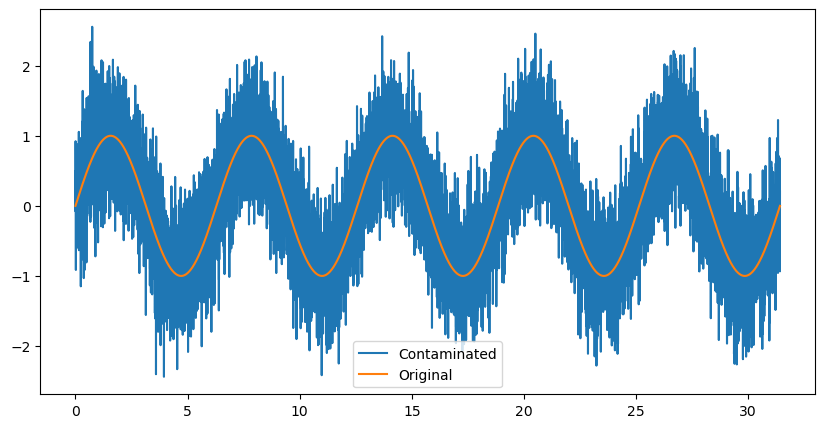

In [17]:
# Plot the original and the contaminated signals
plt.figure(figsize=(10,5))
plt.plot(t, contaminated_signal, label="Contaminated")
plt.plot(t, original_signal, label="Original")
plt.legend()
plt.show()


In [6]:
#TODO: understand what the fuck I did last time

def create_sequences(input_data, output_data, seq_length):
    xs = []
    ys = []
    
    for i in range( len( input_data ) - seq_length ):
        x = input_data[i:(i+seq_length)]
        y = output_data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 75
X, y = create_sequences(contaminated_signal, original_signal, seq_length)

# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
# Reshape the inputs for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()

# First LSTM layer with reduced dropout and L1 regularization
model.add(LSTM(128, input_shape=(X_train.shape[1], 1), return_sequences=True,
               dropout=0.05, recurrent_dropout=0.05, 
               kernel_regularizer=l1(0.0001), recurrent_regularizer=l1(0.0001)))
"""
# Second LSTM layer with reduced dropout and L1 regularization
model.add(LSTM(256, return_sequences=True, 
               dropout=0.05, recurrent_dropout=0.05,
               kernel_regularizer=l1(0.0001), recurrent_regularizer=l1(0.0001)))

# Third LSTM layer with reduced dropout and L2 regularization
model.add(LSTM(128, return_sequences=True, 
               dropout=0.05, recurrent_dropout=0.05,
               kernel_regularizer=l2(0.0001), recurrent_regularizer=l2(0.0001)))
"""
# Fourth LSTM layer with reduced dropout and L2 regularization
model.add(LSTM(64, return_sequences=False, 
               dropout=0.05, recurrent_dropout=0.05,
               kernel_regularizer=l2(0.0001), recurrent_regularizer=l2(0.0001)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=Adam())

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), shuffle=False)


Epoch 1/10
 40/249 [===>..........................] - ETA: 1:12 - loss: 0.2490

KeyboardInterrupt: 

In [ ]:
# Create sequences for all data
X_all, y_all = create_sequences(contaminated_signal, original_signal, seq_length)

# Reshape the inputs for LSTM
X_all = np.reshape(X_all, (X_all.shape[0], X_all.shape[1], 1))

# Make predictions on all data
y_pred_all = model.predict(X_all)

# Shift the predicted data
y_pred_all_shifted = np.roll(y_pred_all, shift=seq_length, axis=0)

# Since we can't predict the first 'seq_length' samples with this method, we can just set them to zero
y_pred_all_shifted[:seq_length] = 0

# Now 'y_pred_all_shifted' should be directly comparable with 'original_signal'.


311/311 [==============================] - 15s 47ms/step


In [ ]:
# Trim the original signal to match the predicted signal
original_signal_trimmed = original_signal[seq_length:-seq_length]

# Now original_signal_trimmed and y_pred_all should have the same shape

In [ ]:
mape_1 = MAPE(original_signal_trimmed, y_pred_all)
print("MAPE: ", mape_1)

MAPE:  392.17611988102334


In [ ]:
sigma_e = metrics.re(original_signal_trimmed, y_pred_all)
print("Sigma_e: ", sigma_e)

NameError: name 'original_signal_trimmed' is not defined

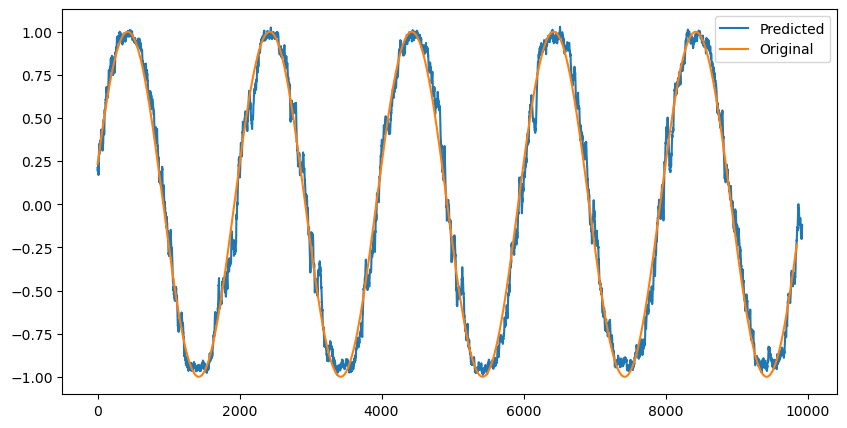

In [ ]:
# Plot the predicted vs trimmed original signal
plt.figure(figsize=(10,5))
plt.plot(y_pred_all, label="Predicted")
plt.plot(original_signal_trimmed, label="Original")
plt.legend()
plt.show()

# Implicaciones del uso de L1 y Dropout

Al momento de agregar estas 2 herramientas se crean "valles" en los picos de las señales, pero a pesar de esto estas 2 tecnicas tienen efectos positivos en el indice de RMSE

# Resultados de aumento en la complejidad

Se observa una mejora considerable en los resultados al aumentar la cantidad de capas y neuronas

Remuestrear señales